# 1) 한미 상대 모멘텀 전략

In [1]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

def getCloseDataPandas(ticker, start, end):
    return data.get_data_yahoo(ticker, start, end)['Close']


def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]


def getPortfolioResult(closeDataSet, weight=None):

    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)

    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getEvaluation(cumulativeReturn):

    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd


def getRebalancingDate(closeDataSet, period="month"):

    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index

    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]
                                * len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
        
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        if(netCumReturn.iloc[-1].sum() ==0):
            totalAsset =1
        else:
            totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn




In [3]:
kospi =getCloseData("069500","2012","2022-10-31") 
SPY = getCloseDataPandas("SPY","2012", "2022-10-31")

closeDataSet = pd.concat([kospi, SPY], axis=1)
closeDataSet.columns = ['kospi','SPY']
closeDataSet.dropna(inplace=True)
closeDataSet

,kospi,SPY
Date,,
2012-01-03,20783.0,127.500000
2012-01-04,20665.0,127.699997
2012-01-05,20630.0,128.039993
2012-01-06,20339.0,127.709999
2012-01-09,20080.0,128.020004
...,...,...
2022-10-25,29198.0,384.920013
2022-10-26,29397.0,382.019989
2022-10-27,29910.0,379.980011


In [4]:
rebalDate = getRebalancingDate(closeDataSet)
priceOnRebalDate = closeDataSet.loc[rebalDate]
priceOnRebalDate

,kospi,SPY
Date,,
2012-01-31,21668.0,131.320007
2012-02-29,22476.0,137.020004
2012-03-30,22437.0,140.809998
2012-04-30,22316.0,139.869995
2012-05-31,20585.0,131.470001
...,...,...
2022-06-30,30700.0,377.250000
2022-07-29,32272.0,411.989990
2022-08-31,32117.0,395.179993


In [5]:
dataweight = priceOnRebalDate.copy()
dataweight['k'] = (dataweight['kospi'] - dataweight['kospi'].shift(12)).fillna(0)
dataweight['s'] = (dataweight['SPY']-dataweight['SPY'].shift(12)).fillna(0)

In [6]:
dataweight['kospi'] = np.where(dataweight['k']>dataweight['s'] , 1,0)
dataweight['SPY'] = np.where(dataweight['k']<dataweight['s'] , 1,0)
dataweight = dataweight.drop(['k','s'], axis=1)

In [7]:
dataweight

,kospi,SPY
Date,,
2012-01-31,0,0
2012-02-29,0,0
2012-03-30,0,0
2012-04-30,0,0
2012-05-31,0,0
...,...,...
2022-06-30,0,1
2022-07-29,0,1
2022-08-31,0,1


In [8]:
_, CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=dataweight)
print(f"달러 ETF 포함 리밸런싱 최종수익률: {CumReturn.iloc[-1]}")
cagr, dd, mdd = getEvaluation(CumReturn)


달러 ETF 포함 리밸런싱 최종수익률: 2.530763795290565
최종 수익률: 2.530763795290565
cagr: 1.0954355612930184
mdd: 35.40858969471376


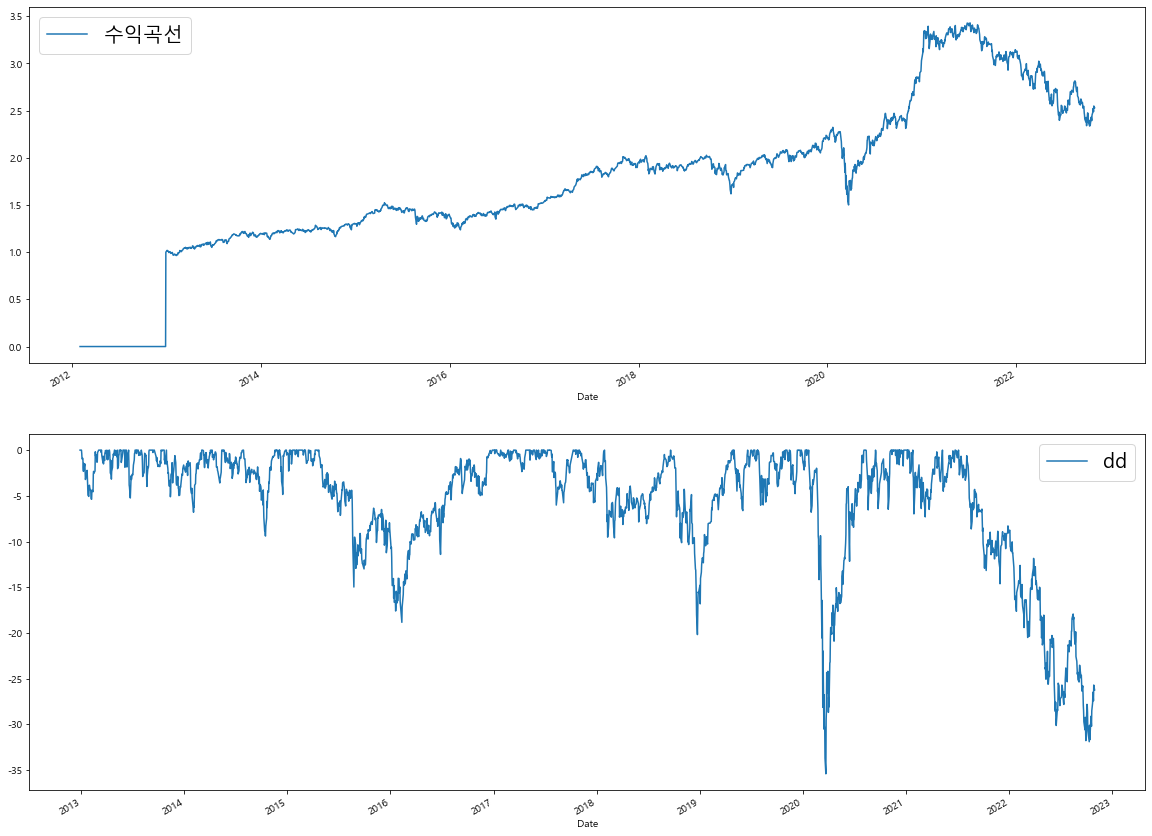

In [9]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
CumReturn.plot(label="수익곡선")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd).plot(label="dd")
plt.legend(fontsize=20)

plt.show()